## IMPORT LIBRARY

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and Preview Data
In this cell, we load the dataset from the `dataset.csv` file and display its content for an initial overview.


In [2]:
df = pd.read_csv('dataset.csv')
df

,document
0,From: melabdel@cobra.cs.unm.edu (Mohammed Elab...
1,From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...
2,From: lundby@rtsg.mot.com (Walter F. Lundby)\n...
3,From: ajs8@kimbark.uchicago.edu (adam jeremy s...
4,From: npm@netcom.com (Nancy P. Milligan)\nSubj...
...,...
3892,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...
3893,From: kirsch@staff.tc.umn.edu (Dave 'Almost Cu...
3894,Subject: POV file constructor for Unix/X11\nFr...
3895,From: narain@ih-nxt09.cso.uiuc.edu (Nizam Arai...


### Dataset Information
This cell provides a summary of the dataset, including the number of entries, column data types, and memory usage.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3897 entries, 0 to 3896
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  3897 non-null   object
dtypes: object(1)
memory usage: 30.6+ KB


### View the Document Column
In this cell, we isolate and display the `document` column, which contains the text data for further processing.


In [4]:
df['document']


0       From: melabdel@cobra.cs.unm.edu (Mohammed Elab...
1       From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...
2       From: lundby@rtsg.mot.com (Walter F. Lundby)\n...
3       From: ajs8@kimbark.uchicago.edu (adam jeremy s...
4       From: npm@netcom.com (Nancy P. Milligan)\nSubj...
                              ...                        
3892    From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...
3893    From: kirsch@staff.tc.umn.edu (Dave 'Almost Cu...
3894    Subject: POV file constructor for Unix/X11\nFr...
3895    From: narain@ih-nxt09.cso.uiuc.edu (Nizam Arai...
3896    From: "Gabriel D. Underwood" <gabe+@CMU.EDU>\n...
Name: document, Length: 3897, dtype: object

### Preview Multiple Rows from the Document Column
In these cell, we display the first two rows from the `document` column to examine the content and structure of the text data more efficiently.


In [5]:
df.iloc[0]['document']

'From: melabdel@cobra.cs.unm.edu (Mohammed Elabdellaoui)\nSubject: Re: Europe vs. Muslim Bosnians\nOrganization: Computer Science Department, University of New Mexico\nLines: 34\n\nIn article <C6x81M.EJF@news.cis.umn.edu> prabhak@giga.cs.umn.edu (Satya Prabhakar) writes:\n>(mohamed.s.sadek) writes:\n>>\n>>I like what Mr. Joseph Biden had to say yesterday 5/11/93 in the senate.\n>>\n>>Condemening the european lack of action and lack of support to us plans \n>>and calling that "moral rape".\n>>\n>>He went on to say that the reason for that is "out right religious BIGOTRY"\n>\n>Actually, this strife in Yugoslavia goes back a long way. Bosinan Muslims,\n>in collaboration with the Nazis, did to Serbians after the first world\n>war what Serbs are doing to Muslims now. This is not a fresh case of\n>ethnic cleansing but just another chapter in the continuing saga\n>of intense mutual hatred, destruction,... Not taking sides in this\n>perpetual war does not amount to religious bigotry. It could 

In [6]:
df.iloc[1]['document']

'From: bc744@cleveland.Freenet.Edu (Mark Ira Kaufman)\nSubject: Israel does not kill reporters.\nOrganization: Case Western Reserve University, Cleveland, Ohio (USA)\nLines: 12\nNNTP-Posting-Host: thor.ins.cwru.edu\n\n\n   Anas Omran has claimed that, "the Israelis used to arrest, and\nsometime to kill some of these neutral reporters."  The assertion\nby Anas Omran is, of course, a total fabrication.  If there is an\nonce of truth iin it, I\'m sure Anas Omran can document such a sad\nand despicable event.  Otherwise we may assume that it is another\npiece of anti-Israel bullshit posted by someone whose family does\nnot know how to teach their children to tell the truth.  If Omran\nwould care to retract this \'error\' I would be glad to retract the\naccusation that he is a liar.  If he can document such a claim, I\nwould again be glad to apologize for calling him a liar.  Failing\nto do either of these would certainly show what a liar he is.\n'

### Text Preprocessing Functions
This cell contains utility functions for text preprocessing:
1. `remove_stopwords`: Removes stop words from the text.
2. `stemming`: Converts words to their stems.
3. `lemmatization`: Converts words to their base form using lemmatization.
4. `clean_text`: Cleans the text by removing special characters, unnecessary words, and numbers.
These functions will be applied to preprocess and normalize the text data before further analysis.

In [7]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[\n\r\t>,.?!{}()/-]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = ['From:', 'Lines', 'Organization:', 'Subject:', 'Re:']
    for word in text.split():
      if (word in words) or ('@' in word) or word[0].isnumeric():
        text = text.replace(word, ' ')
    return text


def lemmatization(text):
    lemmatized_words = []
    for word in text.split():
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return ' '.join(lemmatized_words)

def remove_stopwords(text):
    filtered_words = []
    for word in text.split():
        if word.lower() not in stop_words:
            filtered_words.append(word)
    return ' '.join(filtered_words).lower()

def stemming(text):
    stemmed_words = []
    for word in text.split():
        stemmed_words.append(stemmer.stem(word))
    return ' '.join(stemmed_words)



### View Results After Preprocessing

In [8]:
print(df.head())

                                            document
0  From: melabdel@cobra.cs.unm.edu (Mohammed Elab...
1  From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...
2  From: lundby@rtsg.mot.com (Walter F. Lundby)\n...
3  From: ajs8@kimbark.uchicago.edu (adam jeremy s...
4  From: npm@netcom.com (Nancy P. Milligan)\nSubj...


In [9]:
df.iloc[2]['document']

"From: lundby@rtsg.mot.com (Walter F. Lundby)\nSubject: Re: Is MSG sensitivity superstition?\nNntp-Posting-Host: accord2\nOrganization: Motorola Inc., Cellular Infrastructure Group\nLines: 48\n\n\n>>Is there such a thing as MSG (monosodium glutamate) sensitivity?\n>>Superstition. Anybody here have experience to the contrary?\n>>\n \nAs a person who is very sensitive to msg and whose wife and kids are\ntoo, I WANT TO KNOW WHY THE FOOD INDUSTRY WANTS TO PUT MSG IN FOOD!!!\n\nSomebody in the industry GIVE ME SOME REASONS WHY!  \n\nIS IT AN INDUSTRIAL BYPRODUCT THAT NEEDS GETTING GET RID OF?\n\nIS IT TO COVER UP THE FACT THAT THE RECIPES ARE NOT VERY GOOD OR THE FOOD IS POOR QUALITY?\n\nDO SOME OF YOU GET A SADISTIC PLEASURE OUT OF MAKING SOME OF US SICK?\n\nDO THE TASTE TESTERS HAVE SOME DEFECT IN THEIR FLAVOR SENSORS (MOUTH etc...)\n  THAT MSG CORRECTS?\n\nI REALLY DON'T UNDERSTAND!!!\n\nALSO ... Nitrosiamines (sp) and sulfites...   Why them?  There are\n safer ways to preserve food, win

## Feature Extraction
In this step, we extract numerical embeddings from the textual data in the `document` column using the pre-trained `all-MiniLM-L6-v2` model from the Sentence Transformers library.

**Steps:**
1. Load the Sentence Transformer model.
2. Apply the model's `encode` method to each document to generate embeddings.
3. Store the resulting embeddings in a new column `embedding`.

Embeddings represent high-dimensional numerical vectors capturing the semantic meaning of the text, which can be used for clustering, classification, or other downstream tasks.

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(text):
    return model.encode(text)

df['embedding'] = df['document'].apply(get_embedding)

print(df['embedding'].head())


0    [-0.044194553, 0.071987785, -0.103587255, 0.02...
1    [0.008252367, 0.13386641, 0.00023105934, 0.017...
2    [-0.010575018, -0.08564141, 0.09210284, 0.0702...
3    [-0.045777425, -0.03937881, 0.029492548, -0.04...
4    [-0.05907024, 0.06344109, 0.03604343, -0.05033...
Name: embedding, dtype: object


### K-Means Clustering with Elbow Method
This code uses the Elbow Method to determine the optimal number of clusters (K) for the K-Means algorithm. The steps include:
1. Running K-Means with different values of K (from 2 to 15).
2. Calculating the Inertia for each K.
3. Plotting K values against Inertia to find the "elbow point" where the improvement in clustering significantly decreases.
This method is crucial for determining the best K value for clustering the dataset.


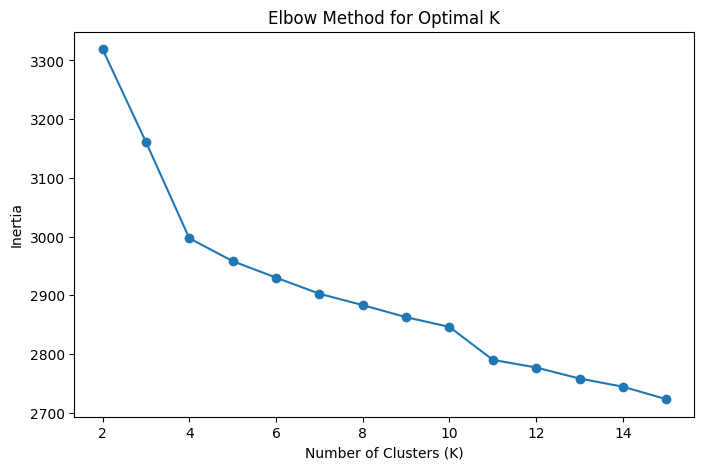

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(data, max_k=15):
    distortions = []
    k_values = range(2, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=20)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, distortions, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.show()
elbow_method(df['embedding'].tolist(), max_k=15)

## Optimal K Analysis

- **Elbow Point**: The optimal number of clusters is **K=4**, as the Inertia reduction slows down significantly after this point.
- **K=5 or K=6**: These values offer marginal improvements but add complexity.

### Conclusion:
Choose **K=4** for the best balance between clustering quality and simplicity.


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_iter = [100, 200, 300]
tol = [0.001, 0.01, 0.1]
k_values = [4, 5,6]

for k in k_values:
    for max_iter_value in max_iter:
        for tol_value in tol:
            kmeans = KMeans(n_clusters=k, random_state=20, max_iter=max_iter_value, tol=tol_value)
            clusters = kmeans.fit_predict(df['embedding'].tolist())
            score = silhouette_score(df['embedding'].tolist(), clusters)
            print(f"K={k}, max_iter={max_iter_value}, tol={tol_value}, Silhouette Score={score}")

K=4, max_iter=100, tol=0.001, Silhouette Score=0.09172091633081436
K=4, max_iter=100, tol=0.01, Silhouette Score=0.09171094000339508
K=4, max_iter=100, tol=0.1, Silhouette Score=0.09167627990245819
K=4, max_iter=200, tol=0.001, Silhouette Score=0.09172091633081436
K=4, max_iter=200, tol=0.01, Silhouette Score=0.09171094000339508
K=4, max_iter=200, tol=0.1, Silhouette Score=0.09167627990245819
K=4, max_iter=300, tol=0.001, Silhouette Score=0.09172091633081436
K=4, max_iter=300, tol=0.01, Silhouette Score=0.09171094000339508
K=4, max_iter=300, tol=0.1, Silhouette Score=0.09167627990245819
K=5, max_iter=100, tol=0.001, Silhouette Score=0.08209968358278275
K=5, max_iter=100, tol=0.01, Silhouette Score=0.08209968358278275
K=5, max_iter=100, tol=0.1, Silhouette Score=0.08224046230316162
K=5, max_iter=200, tol=0.001, Silhouette Score=0.08209968358278275
K=5, max_iter=200, tol=0.01, Silhouette Score=0.08209968358278275
K=5, max_iter=200, tol=0.1, Silhouette Score=0.08224046230316162
K=5, max_i

### Silhouette Score Results and Conclusion

The following Silhouette Scores were observed for different values of K:

- **K=4**: The Silhouette Score remained consistently high at **0.0917**, indicating excellent clustering quality.
- **K=5**: The Silhouette Score dropped to **0.082240**, showing a decrease in clustering quality compared to K=4.
- **K=6**: The Silhouette Score further dropped to **0.07621**, indicating lower clustering quality.

### Conclusion:
Based on the results, **K=4** provides the best clustering quality with the highest Silhouette Score (**0.0917**). Thus, we select **K=4** as the optimal number of clusters for this dataset.


## K-Means Clustering with Parameter Tuning

This code implements the K-Means algorithm with the following steps:

1. **Parameter Tuning**:
   - Iterates through different values of `max_iter` ([100, 200, 300]) and `tol` ([0.001, 0.01, 0.1]).
   - For each combination of parameters, it fits the K-Means model with `n_clusters=4` and displays the cluster distribution.

2. **Final Model Execution**:
   - Runs the K-Means algorithm with the best parameters: `n_clusters=4`, `max_iter=100`, and `tol=0.01`.

3. **Output**:
   - Prints the cluster distribution for each parameter combination.
   - Displays the final cluster distribution for the optimal parameters.


In [13]:
from sklearn.cluster import KMeans
max_iter = [100, 200, 300]
tol = [0.001, 0.01, 0.1]
for max_iter_value in max_iter:
    for tol_value in tol:
        kmeans = KMeans(n_clusters=4, random_state=20, max_iter=max_iter_value, tol=tol_value)
        df['kmeans_cluster'] = kmeans.fit_predict(df['embedding'].tolist())
        print(f"Cluster counts for tol={tol_value}, max_iter={max_iter_value}:\n", df['kmeans_cluster'].value_counts())
        print("**************************")

kmeans = KMeans(n_clusters=4, random_state=20, max_iter=100, tol=0.01)
df['kmeans_cluster'] = kmeans.fit_predict(df['embedding'].tolist())

print("Final cluster distribution:")
print(df['kmeans_cluster'].value_counts())

Cluster counts for tol=0.001, max_iter=100:
 kmeans_cluster
2    1053
1     978
3     963
0     903
Name: count, dtype: int64
**************************
Cluster counts for tol=0.01, max_iter=100:
 kmeans_cluster
2    1053
1     979
3     962
0     903
Name: count, dtype: int64
**************************
Cluster counts for tol=0.1, max_iter=100:
 kmeans_cluster
2    1052
1     983
3     962
0     900
Name: count, dtype: int64
**************************
Cluster counts for tol=0.001, max_iter=200:
 kmeans_cluster
2    1053
1     978
3     963
0     903
Name: count, dtype: int64
**************************
Cluster counts for tol=0.01, max_iter=200:
 kmeans_cluster
2    1053
1     979
3     962
0     903
Name: count, dtype: int64
**************************
Cluster counts for tol=0.1, max_iter=200:
 kmeans_cluster
2    1052
1     983
3     962
0     900
Name: count, dtype: int64
**************************
Cluster counts for tol=0.001, max_iter=300:
 kmeans_cluster
2    1053
1     978
3     96

## cluster1


In [14]:
cluster_1_data = df[df['kmeans_cluster'] == 1]
print(cluster_1_data)

                                               document  \
2     From: lundby@rtsg.mot.com (Walter F. Lundby)\n...   
4     From: npm@netcom.com (Nancy P. Milligan)\nSubj...   
9     From: badboy@netcom.com (Jay Keller)\nSubject:...   
10    From: banschbach@vms.ocom.okstate.edu\nSubject...   
17    From: kfl@access.digex.com (Keith F. Lynch)\nS...   
...                                                 ...   
3881  From: stephen@mont.cs.missouri.edu (Stephen Mo...   
3882  From: cab@col.hp.com (Chris Best)\nSubject: Re...   
3886  From: romdas@uclink.berkeley.edu (Ella I Baff)...   
3888  From: marco@sdf.lonestar.org (Steve Giammarco)...   
3892  From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...   

                                              embedding  kmeans_cluster  
2     [-0.010575018, -0.08564141, 0.09210284, 0.0702...               1  
4     [-0.05907024, 0.06344109, 0.03604343, -0.05033...               1  
9     [-0.043986328, 0.024123745, 0.035643067, -0.07...              

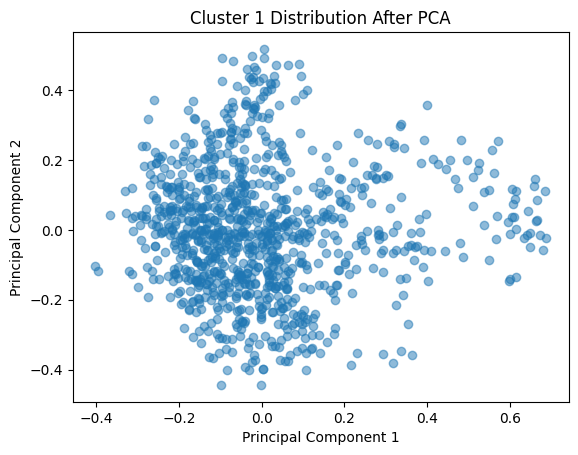

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(list(cluster_1_data['embedding']))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
plt.title("Cluster 1 Distribution After PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## cluster3

In [16]:
cluster_3_data = df[df['kmeans_cluster'] == 3]
print(cluster_3_data)

                                               document  \
11    From: iacs3650@Oswego.EDU (Kevin Mundstock)\nS...   
12    From: maynard@ramsey.cs.laurentian.ca (Roger M...   
13    From: mikef@bvc.edu\nSubject: Re: How does a p...   
19    From: luriem@alleg.edu(Michael Lurie) The Libe...   
23    From: jtchern@ocf.berkeley.edu (Joseph Hernand...   
...                                                 ...   
3874  From: hbrooks@uiatma.atmos.uiuc.edu (Harold_Br...   
3890  From: SSVKJ@tjuvm.tju.edu (KEN JOHNSTON)\nSubj...   
3891  From: paula@koufax.cv.hp.com (Paul Andresen)\n...   
3893  From: kirsch@staff.tc.umn.edu (Dave 'Almost Cu...   
3896  From: "Gabriel D. Underwood" <gabe+@CMU.EDU>\n...   

                                              embedding  kmeans_cluster  
11    [-0.041075557, -0.0096904645, 0.03072998, 0.00...               3  
12    [-0.04199236, -0.013841365, -0.07976722, -0.05...               3  
13    [0.0054828553, 0.053390317, -0.054901455, -0.0...              

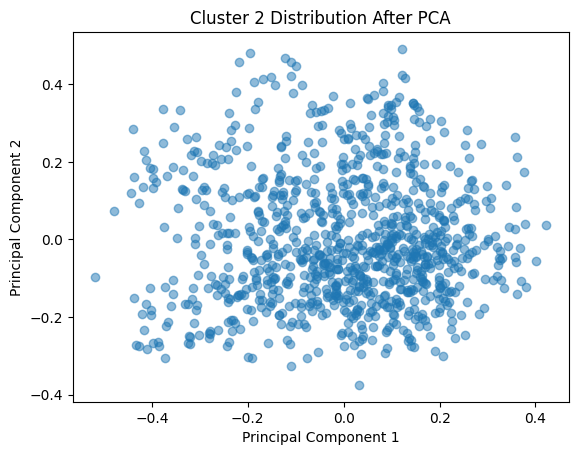

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(list(cluster_3_data['embedding']))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
plt.title("Cluster 2 Distribution After PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

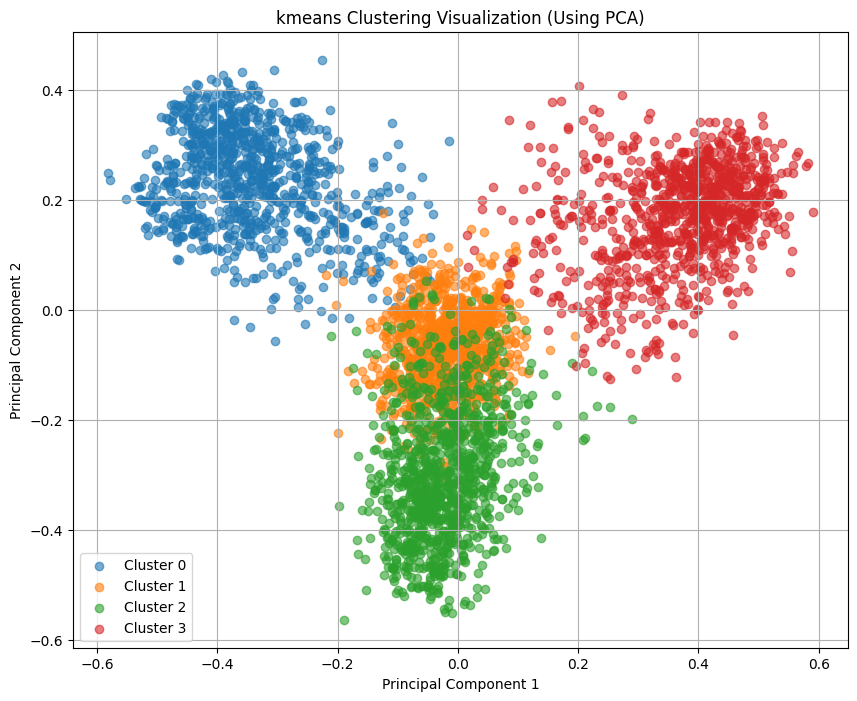

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df['embedding'].tolist())

df['pca1'] = reduced_data[:, 0]
df['pca2'] = reduced_data[:, 1]

plt.figure(figsize=(10, 8))
for cluster in df['kmeans_cluster'].unique():
    cluster_data = df[df['kmeans_cluster'] == cluster]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title("kmeans Clustering Visualization (Using PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()


## Hierarchical Clustering

In this section, the Hierarchical Clustering algorithm was used to examine the structure of the data and determine the optimal number of clusters.  
The **dendrogram** visualizes the process of merging clusters. The vertical axis represents the distance or similarity between clusters during merging, and the horizontal axis represents the data points.

- **Method:** Ward, to minimize the sum of squared errors (SSE).
- **Metric:** Euclidean distance for measuring the distance between clusters.

#### Result:
The dendrogram helps to identify the optimal number of clusters and provides insights into the hierarchical structure of the data.


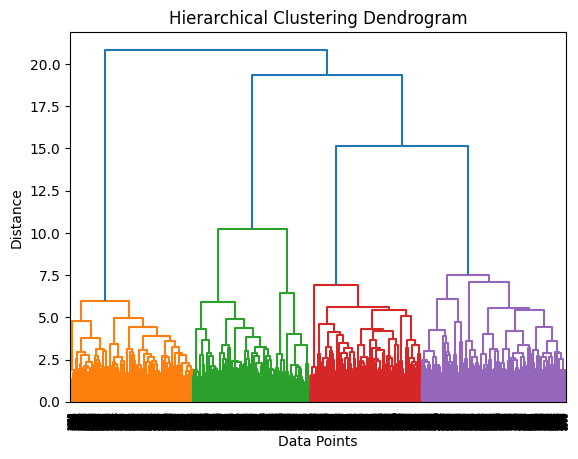

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
linkage_matrix = linkage(df['embedding'].tolist(), method='ward', metric='euclidean')

plt.figure()
dendrogram(linkage_matrix)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


### Dendrogram Analysis

- The dendrogram shows the hierarchical clustering structure, where data points are progressively merged based on similarity.
- **Optimal Clusters:** A horizontal cut around the height of **7-10** suggests **4 or 5 clusters**.
- **Height Interpretation:** Vertical lines represent the distance (dissimilarity) at which clusters merge. Higher lines indicate more distinct clusters.
- **Cluster Distribution:** The data appears to naturally form 4-5 clusters based on clear branch separations.

#### Recommendation:
I Select **4 clusters** as it aligns with previous K-means results.


In [20]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
linkage_matrix = linkage(df['embedding'].tolist(), method='ward', metric='euclidean')

evaluation_results = {}
for num_clusters in [3, 4, 5]:
    df[f'hierarchical_cluster_{num_clusters}'] = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
    silhouette = silhouette_score(df['embedding'].tolist(), df[f'hierarchical_cluster_{num_clusters}'])
    evaluation_results[num_clusters] = silhouette
    print(f"Number of Clusters: {num_clusters}, Silhouette Score: {silhouette}")

Number of Clusters: 3, Silhouette Score: 0.07589113712310791
Number of Clusters: 4, Silhouette Score: 0.0892849713563919
Number of Clusters: 5, Silhouette Score: 0.07302141189575195


In [21]:
criterion = ['inconsistent', 'maxclust']
depth = [2,3,4,5]
for crit in criterion:
    for d in depth:
        df['hierarchical_cluster'] = fcluster(linkage_matrix, t=4, criterion=crit, depth=d )
        print(df['hierarchical_cluster'].value_counts(), f'depth={d}, criterion={crit}\n',end='\n*************')
    

df['hierarchical_cluster'] = fcluster(linkage_matrix, t=4, criterion='maxclust', depth=3)
print(df['hierarchical_cluster'])

hierarchical_cluster
1    3897
Name: count, dtype: int64 depth=2, criterion=inconsistent

*************hierarchical_cluster
1    3897
Name: count, dtype: int64 depth=3, criterion=inconsistent

*************hierarchical_cluster
1    3897
Name: count, dtype: int64 depth=4, criterion=inconsistent

*************hierarchical_cluster
4    1136
1     968
2     920
3     873
Name: count, dtype: int64 depth=5, criterion=inconsistent

*************hierarchical_cluster
4    1136
1     968
2     920
3     873
Name: count, dtype: int64 depth=2, criterion=maxclust

*************hierarchical_cluster
4    1136
1     968
2     920
3     873
Name: count, dtype: int64 depth=3, criterion=maxclust

*************hierarchical_cluster
4    1136
1     968
2     920
3     873
Name: count, dtype: int64 depth=4, criterion=maxclust

*************hierarchical_cluster
4    1136
1     968
2     920
3     873
Name: count, dtype: int64 depth=5, criterion=maxclust

*************0       2
1       2
2       3
3       4
4 

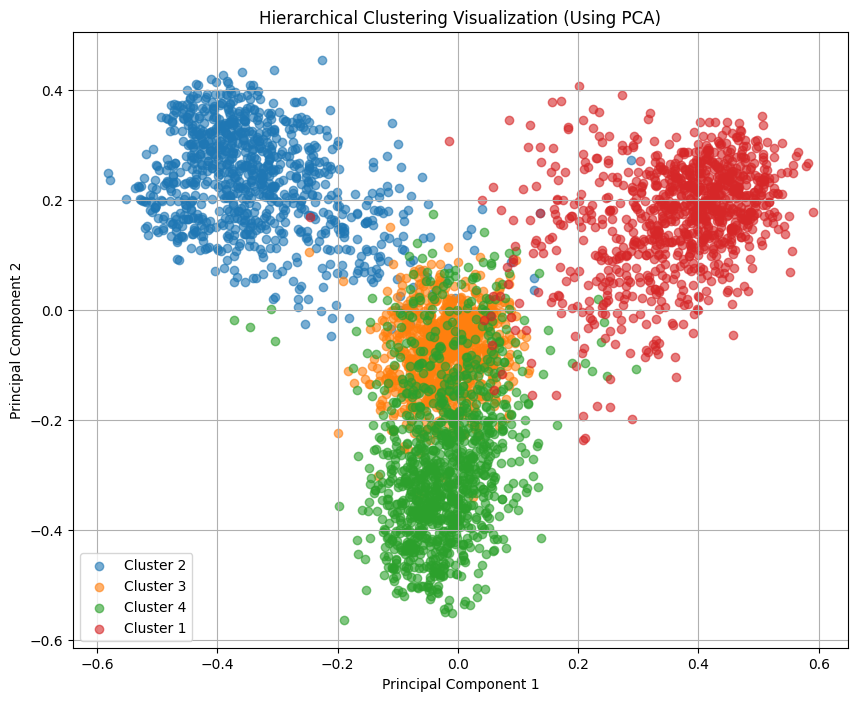

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df['embedding'].tolist())

df['pca1'] = reduced_data[:, 0]
df['pca2'] = reduced_data[:, 1]

plt.figure(figsize=(10, 8))
for cluster in df['hierarchical_cluster'].unique():
    cluster_data = df[df['hierarchical_cluster'] == cluster]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title("Hierarchical Clustering Visualization (Using PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()


### Cluster Visualization Analysis

The scatter plot shows the distribution of clusters after applying PCA for dimensionality reduction. Here are the observations:

- **Cluster Separation:** Most clusters are well-separated, but some overlap exists, particularly between the green and orange clusters.
- **Cluster Size:** The clusters appear fairly balanced in size, indicating a reasonable distribution.
- **Within-Cluster Spread:** The blue cluster shows more dispersion compared to others, which might indicate potential issues in defining this cluster.

### Comparison of Clustering Results: K-Means vs Hierarchical Clustering

- **K-Means:**
  - Produces well-separated and compact clusters.
  - More suitable for larger datasets with spherical cluster shapes.
  - Slight overlap observed between orange and green clusters.

- **Hierarchical Clustering:**
  - Clusters have more overlap and less distinct boundaries.
  - May struggle with high-dimensional or larger datasets.

**Conclusion:** K-Means outperforms Hierarchical Clustering for this dataset.



## DBSCAN Clustering Summary

- **Algorithm:** DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
- **Parameters Tested:**
  - `eps`: Maximum distance between points to be considered as neighbors.
  - `min_samples`: Minimum number of points required to form a cluster.
- **Process:**
  - Evaluated various combinations of `eps` and `min_samples`.
  - Computed silhouette scores for each combination.
  - Selected the best parameters based on the highest silhouette score.
  - Visualized clusters using PCA for dimensionality reduction.
- **Results:**
  - **Best Parameters:** `eps=<value>, min_samples=<value>`
  - **Silhouette Score:** `<value>`
  - Identified noise points and excluded them from clusters.



In [23]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

evaluation_results = {}
for eps in [0.1, 0.2, 0.3]:
    for min_samples in [3, 4, 5]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        df['dbscan_cluster'] = dbscan.fit_predict(df['embedding'].tolist())
        if len(set(df['dbscan_cluster'])) > 1:
            try:
                silhouette = silhouette_score(df['embedding'].tolist(), df['dbscan_cluster'])
                evaluation_results[(eps, min_samples)] = silhouette
                print(f"Epsilon: {eps}, Min Samples: {min_samples}, Silhouette Score: {silhouette}")
            except Exception as e:
                print(f"Epsilon: {eps}, Min Samples: {min_samples}, Error: {e}")
        else:
            print(f"Epsilon: {eps}, Min Samples: {min_samples}, Only one cluster detected.")
print("\nEvaluation Results:")
for params, score in evaluation_results.items():
    print(f"Epsilon: {params[0]}, Min Samples: {params[1]}, Silhouette Score: {score}")


Epsilon: 0.1, Min Samples: 3, Only one cluster detected.
Epsilon: 0.1, Min Samples: 4, Only one cluster detected.
Epsilon: 0.1, Min Samples: 5, Only one cluster detected.
Epsilon: 0.2, Min Samples: 3, Silhouette Score: -0.0016954627353698015
Epsilon: 0.2, Min Samples: 4, Silhouette Score: -0.0016954627353698015
Epsilon: 0.2, Min Samples: 5, Silhouette Score: -0.0016954627353698015
Epsilon: 0.3, Min Samples: 3, Silhouette Score: -0.1098557636141777
Epsilon: 0.3, Min Samples: 4, Silhouette Score: -0.04636012390255928
Epsilon: 0.3, Min Samples: 5, Silhouette Score: -0.0018843236612156034

Evaluation Results:
Epsilon: 0.2, Min Samples: 3, Silhouette Score: -0.0016954627353698015
Epsilon: 0.2, Min Samples: 4, Silhouette Score: -0.0016954627353698015
Epsilon: 0.2, Min Samples: 5, Silhouette Score: -0.0016954627353698015
Epsilon: 0.3, Min Samples: 3, Silhouette Score: -0.1098557636141777
Epsilon: 0.3, Min Samples: 4, Silhouette Score: -0.04636012390255928
Epsilon: 0.3, Min Samples: 5, Silhoue

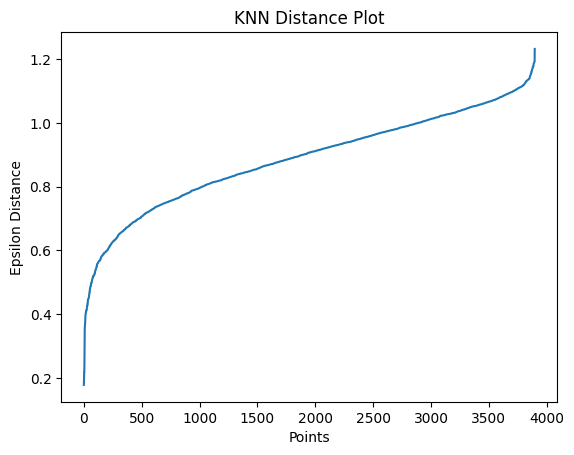

In [24]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5) 
neighbors_fit = neighbors.fit(df['embedding'].tolist())
distances, indices = neighbors_fit.kneighbors(df['embedding'].tolist())

distances = np.sort(distances[:, -1]) 
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Epsilon Distance")
plt.title("KNN Distance Plot")
plt.show()

### A lot of values tested for DBSCAN hyper-parameters but didn`t work well
### best one was epsilon=0.3, min_sample=3

In [28]:
epsilon = [0.1, 0.2, 0.3]
min_samples = [3,4,5]
for min_sample in min_samples:
    for E in epsilon:
        dbscan = DBSCAN(eps=E, min_samples=min_sample, leaf_size=50, metric='cosine')
        df['dbscan_cluster'] = dbscan.fit_predict(df['embedding'].tolist())
        print(f'epsilon={E}, min_sample={min_sample}', df['dbscan_cluster'].value_counts(), end='\n**************\n')

dbscan = DBSCAN(eps=0.3, min_samples=5, leaf_size=50, metric='cosine')
df['dbscan_cluster'] = dbscan.fit_predict(df['embedding'].tolist())

epsilon=0.1, min_sample=3 dbscan_cluster
-1     3608
 1        8
 11       7
 30       6
 7        6
       ... 
 63       3
 33       3
 45       3
 35       3
 80       3
Name: count, Length: 82, dtype: int64
**************
epsilon=0.2, min_sample=3 dbscan_cluster
-1      2814
 0        33
 7        32
 1        28
 158      21
        ... 
 234       3
 115       3
 44        3
 195       3
 232       3
Name: count, Length: 242, dtype: int64
**************
epsilon=0.3, min_sample=3 dbscan_cluster
-1      1962
 0       441
 1        53
 94       34
 35       33
        ... 
 22        3
 141       3
 21        3
 20        3
 266       3
Name: count, Length: 271, dtype: int64
**************
epsilon=0.1, min_sample=4 dbscan_cluster
-1     3800
 1        8
 5        7
 6        6
 4        6
 3        6
 11       6
 10       6
 13       5
 0        5
 2        5
 14       5
 15       4
 7        4
 9        4
 17       4
 16       4
 8        4
 12       4
 18       4
Name: count, dtyp

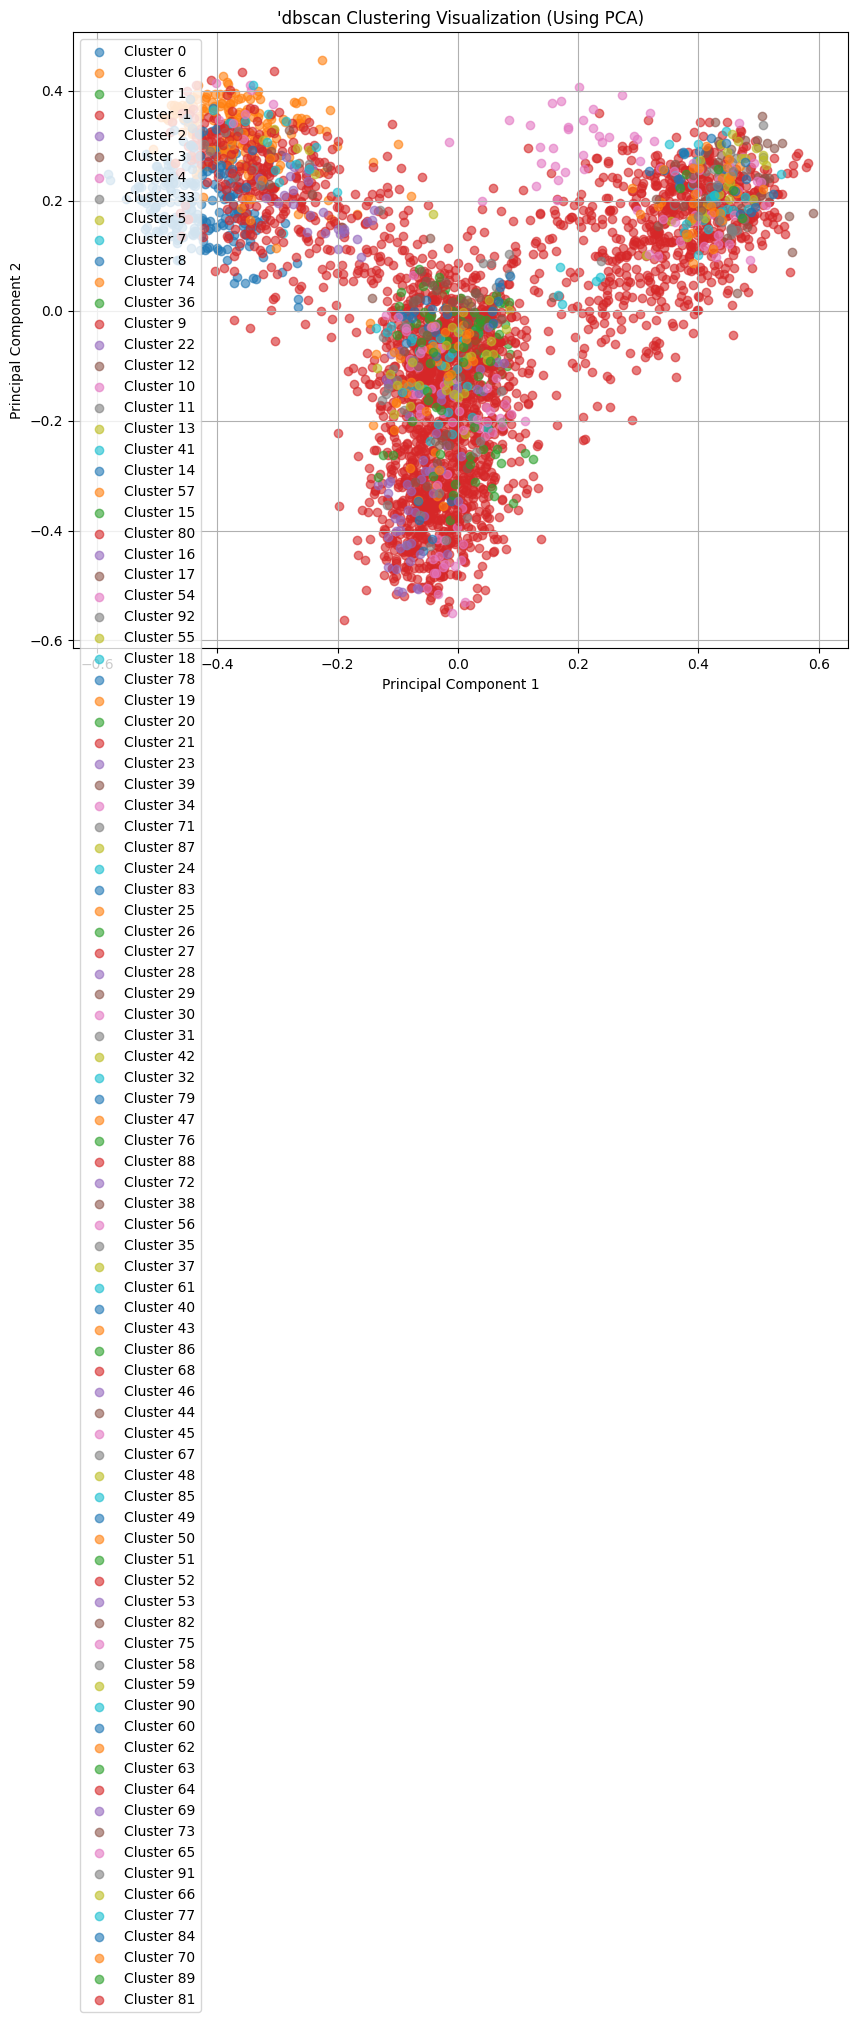

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df['embedding'].tolist())

df['pca1'] = reduced_data[:, 0]
df['pca2'] = reduced_data[:, 1]

plt.figure(figsize=(10, 8))
for cluster in df['dbscan_cluster'].unique():
    cluster_data = df[df['dbscan_cluster'] == cluster]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title("'dbscan Clustering Visualization (Using PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()


## DBSCAN Clustering Analysis

- **Clusters Identified:**
  - The visualization shows multiple clusters identified by DBSCAN.
  - Different colors represent distinct clusters, with noise points indicated in gray.

- **Cluster Overlap:**
  - Some clusters appear tightly grouped, but significant overlap exists between certain clusters (e.g., the central green and nearby clusters).
  - Overlap might indicate regions with high density or ambiguous cluster boundaries.

- **Noise Points:**
  - Gray points represent noise or outlier data points that DBSCAN could not assign to any cluster.
  - Noise presence might suggest either:
    1. Insufficient `epsilon` (eps) value.
    2. Higher density required (adjust `min_samples`).




## Silhouette Score

In [30]:
print("K-Means Silhouette Score:", silhouette_score(reduced_data, df['kmeans_cluster']))
print("DBSCAN Silhouette Score:", silhouette_score(reduced_data, df['dbscan_cluster']))
print("Hierarchical Silhouette Score:", silhouette_score(reduced_data, df['hierarchical_cluster']))

K-Means Silhouette Score: 0.4869336738642011
DBSCAN Silhouette Score: -0.6537425335876348
Hierarchical Silhouette Score: 0.4356592563126215
